In [1]:
from data import load_feature_and_outcome, load_reference_genes
from utils import *

from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import pandas as pd

In [2]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import LinearSVC

In [3]:
gene_names, features, labels, feature_map_tables = load_feature_and_outcome(
    feature_path='./data/sc2_Phase1_CN_FeatureMatrix.tsv',
    phenotype_path='./data/sc2_Phase1_CN_Phenotype.tsv',
    outcome_path='./data/sc2_Phase1_CN_Outcome.tsv',
    shuffle=True
)

# ...single variable correlation

In [4]:
(features_8, labels_8), (features_2, labels_2) = data_split(features, labels, fraction=0.8)

In [5]:
# replicate 1
rank_summary1 = select_feature_by_pearson(features_8, labels_8, replicates=500)
gene_names[np.argsort(rank_summary1)[:30]]

 2/500  

c:\users\flyin\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


 500/500  

array(['RACE', '8q24.13', 'SEX', '9p12', '9p24.1', '9p21.3', '9p24.3',
       '21q11.1', '8q24.21', '5p15.32', '1p31.3', '8q23.2', '1p21.2',
       '19q13.11', '5q21.2', '8q24.3', '8q23.3', '14q32.31', '9p24.2',
       '8q11.22', '19q13.42', '9p21.1', '8q23.1', '7p12.1', '8q24.12',
       '2p13.2', '15q21.3', '13q21.32', '14q32.33', '7p11.2'],
      dtype='<U11')

In [6]:
# replicate 2
rank_summary2 = select_feature_by_pearson(features_8, labels_8, replicates=500)
gene_names[np.argsort(rank_summary2)[:30]]

 500/500  

array(['RACE', 'SEX', '8q24.13', '9p12', '9p21.3', '9p24.1', '9p24.3',
       '8q24.21', '21q11.1', '5p15.32', '19q13.11', '1p31.3', '1p21.2',
       '8q24.3', '19q13.42', '9p24.2', '8q23.2', '8q23.3', '5q21.2',
       '14q32.31', '9p21.1', '8q23.1', '8q11.22', '7p12.1', '8q24.12',
       '15q21.3', '13q21.32', '2p13.2', '7p11.2', '9p23'], dtype='<U11')

In [7]:
# replicate 3
rank_summary3 = select_feature_by_pearson(features_8, labels_8, replicates=500)
gene_names[np.argsort(rank_summary3)[:30]]

 500/500  

array(['RACE', 'SEX', '8q24.13', '9p12', '9p21.3', '9p24.1', '9p24.3',
       '21q11.1', '8q24.21', '5p15.32', '1p31.3', '8q24.3', '8q23.3',
       '19q13.11', '8q23.2', '1p21.2', '5q21.2', '9p24.2', '8q23.1',
       '19q13.42', '14q32.31', '8q11.22', '2p13.2', '8q24.12', '7p12.1',
       '9p21.1', '13q21.32', '8q24.11', '8q22.2', '7p11.2'], dtype='<U11')

In [8]:
# final replicate
rank_summary = select_feature_by_pearson(features_8, labels_8, replicates=5000)
gene_names[np.argsort(rank_summary)[:30]]

 5000/5000  

array(['RACE', 'SEX', '8q24.13', '9p12', '9p21.3', '9p24.1', '9p24.3',
       '21q11.1', '8q24.21', '5p15.32', '1p31.3', '19q13.11', '8q23.2',
       '8q24.3', '1p21.2', '8q23.3', '5q21.2', '19q13.42', '9p24.2',
       '14q32.31', '8q23.1', '9p21.1', '8q24.12', '7p12.1', '2p13.2',
       '15q21.3', '8q11.22', '13q21.32', '7p11.2', '8q24.11'],
      dtype='<U11')

In [9]:
np.savetxt('gene_ranks_sc2.txt', gene_names[np.argsort(rank_summary)], fmt='%s')

In [10]:
np.save('rank_summary_sc2.npy', rank_summary)

In [20]:
pearson(features_8[:,np.argsort(rank_summary)[:30]], labels_8)[:,0]

array([-0.25437919, -0.23074716, -0.25131871,  0.21259002,  0.21627804,
        0.20596713,  0.19043727, -0.21216037, -0.21159191, -0.20909616,
       -0.19533842, -0.19575576, -0.1892627 , -0.18563615, -0.18840631,
       -0.19027034,  0.16454214, -0.18842818,  0.16739513, -0.18491975,
       -0.18090702,  0.1686591 , -0.18022646,  0.16327667, -0.17639036,
       -0.18135024, -0.17775276, -0.17172553,  0.15963987, -0.17098551])

In [21]:
features.shape

(174, 815)

# Esitmate the number of feature needed for classifier

In [24]:
performance_num_curve = []
baseline_num_curve = []
for i in range(1,200,10):
    
    selected_features = features[:,np.argsort(rank_summary)[:i]]
    print (i)
    for j in range(100):
        dataset = data_split(selected_features, labels)
        performance = test_xgb(dataset, **{
            'n_estimators':200,
            'max_depth':5,
            'min_child_weight':2,
            'n_jobs':8
        })
        baseline = (dataset[0][1].mean(), dataset[1][1].mean())
        performance_num_curve.append(performance)
        baseline_num_curve.append(baseline)

p_gain = np.array(performance_num_curve) - np.array(baseline_num_curve)

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191


In [26]:
p_gain = p_gain.reshape([-1,100,2])
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(np.arange(1,200,10).reshape([-1,1]), p_gain[:,:,1].mean(axis=1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

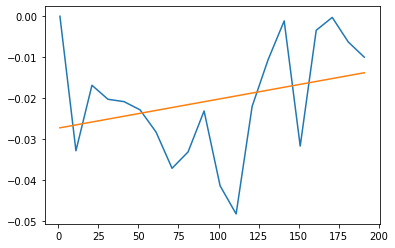

In [27]:
plt.plot(range(1,200,10), p_gain[:,:,1].mean(axis=1))
plt.plot(np.arange(1,200,10), lr.predict(np.arange(1,200,10).reshape([-1,1])))

In [22]:
performance_num_curve = []
baseline_num_curve = []
for i in range(1,800,50):
    
    selected_features = features[:,np.argsort(rank_summary)[:i]]
    print (i)
    for j in range(40):
        dataset = data_split(selected_features, labels)
        performance = test_xgb(dataset, **{
            'n_estimators':200,
            'max_depth':5,
            'min_child_weight':2,
            'n_jobs':8
        })
        baseline = (dataset[0][1].mean(), dataset[1][1].mean())
        performance_num_curve.append(performance)
        baseline_num_curve.append(baseline)
        

p_gain = np.array(performance_num_curve) - np.array(baseline_num_curve)
p_gain = p_gain.reshape([-1,40,2])
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(np.arange(1,800,50).reshape([-1,1]), p_gain[:,:,1].mean(axis=1))

1
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

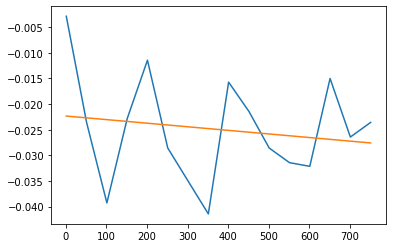

In [23]:
plt.plot(range(1,800,50), p_gain[:,:,1].mean(axis=1))
plt.plot(np.arange(1,800,50), lr.predict(np.arange(1,800,50).reshape([-1,1])))

it seems ??? features should be ok? 180?

# fit feature and classifier params in epoches

In [378]:
selected_feature_final = features[:,np.argsort(rank_summary)[:175]]

In [379]:
selected_feature_names = gene_names[np.argsort(rank_summary)[:175]]

In [380]:
selected_feature_names

array(['RACE', 'SEX', '8q24.13', '9p12', '9p21.3', '9p24.1', '9p24.3',
       '21q11.1', '8q24.21', '5p15.32', '1p31.3', '19q13.11', '8q23.2',
       '8q24.3', '1p21.2', '8q23.3', '5q21.2', '19q13.42', '9p24.2',
       '14q32.31', '8q23.1', '9p21.1', '8q24.12', '7p12.1', '2p13.2',
       '15q21.3', '8q11.22', '13q21.32', '7p11.2', '8q24.11', '14q32.33',
       '8q22.2', '8q24.22', '9p23', '5q14.2', '5q31.2', '14q32.2',
       '1p34.2', '4p16.2', '19q13.13', '19q12', '8q11.23', '8q21.3',
       '3q13.12', '5q11.1', '17p13.2', '16p13.2', '21p11.1', '9p13.1',
       '7p15.3', '7q31.1', '8q21.13', '14q32.11', '1p32.3', '16q12.1',
       '1p31.2', '5p15.33', '10q23.32', '15q13.3', '19q13.41', '5q21.3',
       '21q21.1', '1p22.3', '7p14.3', '17q11.1', '10q24.32', '9q31.2',
       '14q22.2', '3p25.1', '6q16.2', '4p15.1', '7p13', '9p22.2',
       '13q21.33', '7q11.22', '8q22.1', '7p15.1', '2p23.2', '8q13.3',
       '8q12.1', '1p35.1', '2p22.2', '7p14.1', '17q11.2', '17q23.1',
       '1p32.2', 

find a params

In [403]:
params_candidate = {
    'n_estimators':[100,2000],
    'max_depth':[2,3,8],
    'min_child_weight':[2,8,16],
    'n_jobs':[8],
    'colsample_bynode':[0.5,1],
    'gamma':[1.2,0]
}

In [404]:
search_result = grid_search(selected_feature_final, labels, test_xgb, params_candidate, replicates=100)

Running grid search on 72 set of params...
Eval 72.00 of 72 params...      

In [405]:
params_list, scores_list, baseline_list = search_result

In [409]:
averaged_score = (np.array(scores_list) - np.array(baseline_list)).mean(axis=1)

In [414]:
params_list_np = np.array(params_list)

In [420]:
sort_index = np.argsort(-averaged_score[:,1])

In [421]:
sorted_params_list = params_list_np[sort_index]

In [422]:
averaged_score[sort_index]

array([[ 0.20733813,  0.016     ],
       [ 0.20733813,  0.01571429],
       [ 0.21417266,  0.012     ],
       [ 0.21654676,  0.012     ],
       [ 0.21007194,  0.01085714],
       [ 0.21848921,  0.01028571],
       [ 0.21352518,  0.01028571],
       [ 0.21352518,  0.01      ],
       [ 0.21676259,  0.01      ],
       [ 0.23244604,  0.00914286],
       [ 0.23719424,  0.00857143],
       [ 0.22107914,  0.00771429],
       [ 0.22143885,  0.00428571],
       [ 0.23467626,  0.004     ],
       [ 0.21856115,  0.00342857],
       [ 0.21848921,  0.00342857],
       [ 0.22597122,  0.00171429],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [441]:
sorted_params_list

array([{'gamma': 1.2, 'colsample_bynode': 1, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 2, 'n_estimators': 100},
       {'gamma': 1.2, 'colsample_bynode': 1, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 2, 'n_estimators': 2000},
       {'gamma': 1.2, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 2, 'n_estimators': 2000},
       {'gamma': 0, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 2, 'n_estimators': 100},
       {'gamma': 1.2, 'colsample_bynode': 0.5, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 2, 'n_estimators': 100},
       {'gamma': 0, 'colsample_bynode': 1, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 2, 'n_estimators': 100},
       {'gamma': 1.2, 'colsample_bynode': 1, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 3, 'n_estimators': 100},
       {'gamma': 1.2, 'colsample_bynode': 1, 'n_jobs': 8, 'min_child_weight': 2, 'max_depth': 3, 'n_estimators': 2000},
       {'gamma': 1.2, 'colsample_bynode': 0

In [423]:
params = sorted_params_list[0]

In [431]:
params

{'gamma': 1.2,
 'colsample_bynode': 1,
 'n_jobs': 8,
 'min_child_weight': 2,
 'max_depth': 2,
 'n_estimators': 100}

In [440]:
dataset = data_split(selected_feature_final, labels)
baseline = (dataset[0][1].mean(), dataset[1][1].mean())
performance = test_xgb(dataset, **params)
print ((performance),'\n',(baseline))

(0.9640287769784173, 0.7714285714285715) 
 (0.7553956834532374, 0.7428571428571429)


In [397]:
results_single = []

In [398]:
for i in range(100):
    _dataset = data_split(selected_feature_final, labels)
    _baseline = np.array((_dataset[0][1].mean(), _dataset[1][1].mean()))
    results_single.append(np.array(test_clf(_dataset, XGBClassifier, **params)) - _baseline)
    
    print ('perform gain:  %.4f %.4f, %.4f %.4f' % (tuple(results_single[-1]) + tuple(_baseline)))

perform gain:  0.2302 -0.0571, 0.7410 0.8000
perform gain:  0.2302 -0.0286, 0.7338 0.8286
perform gain:  0.2158 0.0000, 0.7554 0.7429
perform gain:  0.1942 0.0571, 0.7770 0.6571
perform gain:  0.2158 0.0857, 0.7626 0.7143
perform gain:  0.1942 0.0857, 0.7698 0.6857
perform gain:  0.2230 0.0000, 0.7410 0.8000
perform gain:  0.2086 0.0000, 0.7554 0.7429
perform gain:  0.2230 0.0286, 0.7482 0.7714
perform gain:  0.2302 0.0571, 0.7554 0.7429
perform gain:  0.2086 0.1143, 0.7626 0.7143
perform gain:  0.2158 -0.1143, 0.7482 0.7714
perform gain:  0.2446 0.0286, 0.7410 0.8000
perform gain:  0.2014 0.0286, 0.7626 0.7143
perform gain:  0.2086 0.0571, 0.7626 0.7143
perform gain:  0.2158 -0.0571, 0.7410 0.8000
perform gain:  0.2158 -0.0286, 0.7554 0.7429
perform gain:  0.1871 0.0286, 0.7698 0.6857
perform gain:  0.2230 -0.0857, 0.7410 0.8000
perform gain:  0.2086 0.0000, 0.7626 0.7143
perform gain:  0.2014 0.0000, 0.7626 0.7143
perform gain:  0.2086 -0.0571, 0.7554 0.7429
perform gain:  0.2158 -0.

KeyboardInterrupt: 

In [399]:
results_single = np.array(results_single)

In [400]:
results_single.mean(axis=0)

array([0.21123102, 0.0015873 ])

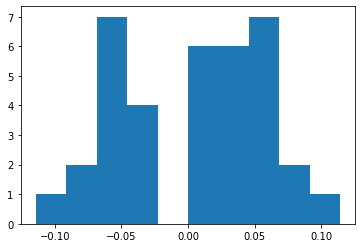

In [401]:
_=plt.hist(results_single[:,1], bins=10)

this params seems to be ok, filter the features.

In [442]:
from xgboost.sklearn import XGBClassifier

In [446]:
train_dataset, valid_dataset = data_split(selected_feature_final, labels, fraction=0.8)

feature_importance = np.zeros(selected_feature_final.shape[1], dtype='float')
for i in range(200):
    print('\r%2d/%2d  ' % (i+1,200), end='')
    _train_dataset, _ = data_split(*train_dataset, fraction=0.8)
    clf = XGBClassifier(**params)
    clf.fit(*_train_dataset)
    feature_importance += clf.feature_importances_
    
feature_importance /= 200

200/200  

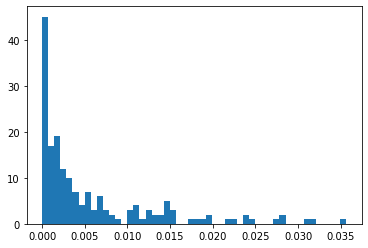

In [447]:
_=plt.hist(feature_importance, bins=50)

it seems 0.010 would be the 1st level, 0.015 be the second level.

In [448]:
# 1st level features
(feature_importance > 0.01).sum()

39

In [449]:
selected_feature_names[feature_importance > 0.01]

array(['RACE', 'SEX', '8q24.13', '9p12', '9p21.3', '9p24.1', '21q11.1',
       '8q24.21', '8q24.3', '1p21.2', '8q23.1', '9p21.1', '8q24.12',
       '5q31.2', '4p16.2', '8q21.3', '5q11.1', '7q31.1', '5q21.3',
       '9q31.2', '3p25.1', '1p32.2', '8q22.3', '1p31.1', '21q11.2',
       '1p34.1', '2p25.3', '9q33.2', '10q11.23', '1p36.31', '5p14.2',
       '12q24.11', '5p14.1', '5q11.2', '9q34.3', '3p12.2', '11p15.4',
       '6q22.33', '13q12.11'], dtype='<U11')

In [452]:
# level 0 features
(feature_importance > 0.015).sum()

19

In [453]:
selected_feature_names[feature_importance > 0.005]

array(['RACE', 'SEX', '8q24.13', '9p12', '9p21.3', '9p24.1', '21q11.1',
       '8q24.21', '5p15.32', '1p31.3', '8q23.2', '8q24.3', '1p21.2',
       '8q23.3', '8q23.1', '9p21.1', '8q24.12', '15q21.3', '7p11.2',
       '14q32.33', '9p23', '5q31.2', '4p16.2', '19q13.13', '8q21.3',
       '5q11.1', '7p15.3', '7q31.1', '16q12.1', '5p15.33', '19q13.41',
       '5q21.3', '9q31.2', '14q22.2', '3p25.1', '2p23.2', '1p32.2',
       '16p12.3', '8q22.3', '1p31.1', '1p33', '21q11.2', '1p34.1',
       '2p25.3', '9q33.2', '10q11.23', '12p11.21', '1p36.31', '5p14.2',
       '12q24.11', '10q24.33', '5p14.1', '5q11.2', '21q21.2', '9q34.3',
       '3p12.2', '11p15.4', '4q33', '3q11.2', '6q22.33', '13q12.11'],
      dtype='<U11')

so test these stages

level 0 newly added

In [454]:
feature_0_stage = selected_feature_final[:,feature_importance > 0.015]
scores_0 = []
baselines_0 = []
for i in range(100):
    print('\r%2d/%2d  ' % (i+1,100), end='')
    dataset = data_split(feature_0_stage, labels, fraction=0.7)
    baseline = (dataset[0][1].mean(), dataset[1][1].mean())
    perform = test_xgb(dataset, **params)
    
    scores_0.append(perform)
    baselines_0.append(baseline)

100/100  

In [455]:
score_0 = np.asarray(scores_0).reshape(-1,2)
baseline_0 = np.array(baselines_0)

In [456]:
(score_0 - baseline_0).mean(axis=0)

array([0.16247934, 0.04528302])

In [457]:
feature_1st_stage = selected_feature_final[:,feature_importance > 0.01]
scores_1st = []
baselines_1st = []
for i in range(100):
    print('\r%2d/%2d  ' % (i+1,100), end='')
    dataset = data_split(feature_1st_stage, labels, fraction=0.7)
    baseline = (dataset[0][1].mean(), dataset[1][1].mean())
    perform = test_xgb(dataset, **params)
    
    scores_1st.append(perform)
    baselines_1st.append(baseline)

100/100  

In [458]:
score_1st = np.asarray(scores_1st).reshape(-1,2)
baseline_1st = np.array(baselines_1st)

In [459]:
(score_1st - baseline_1st).mean(axis=0)

array([0.18933884, 0.02830189])

In [460]:
feature_2nd_stage = selected_feature_final[:,feature_importance > 0.005]
scores_2nd = []
baselines_2nd = []
for i in range(100):
    print('\r%2d/%2d  ' % (i+1,100), end='')
    dataset = data_split(feature_2nd_stage, labels, fraction=0.7)
    baseline = (dataset[0][1].mean(), dataset[1][1].mean())
    perform = test_xgb(dataset, **params)
    
    scores_2nd.append(perform)
    baselines_2nd.append(baseline)

100/100  

In [461]:
score_2nd = np.asarray(scores_2nd).reshape(-1,2)
baseline_2nd = np.array(baselines_2nd)

In [462]:
(score_2nd - baseline_2nd).mean(axis=0)

array([0.19958678, 0.01622642])

there's no doubt to select 1st level

let's check the final feature we selected:

In [463]:
selected_feature_names[feature_importance > 0.015]

array(['RACE', 'SEX', '9p12', '9p21.3', '9p24.1', '8q24.21', '8q24.3',
       '1p21.2', '8q23.1', '5q31.2', '8q21.3', '5q11.1', '7q31.1',
       '5q21.3', '1p32.2', '1p31.1', '10q11.23', '11p15.4', '6q22.33'],
      dtype='<U11')

note: grading and cancer type not in it... but race and sex in it??

In [464]:
params

{'gamma': 1.2,
 'colsample_bynode': 1,
 'n_jobs': 8,
 'min_child_weight': 2,
 'max_depth': 2,
 'n_estimators': 100}

In [465]:
results_single = []

In [466]:
for i in range(100):
    _dataset = data_split(feature_0_stage, labels)
    _baseline = np.array((_dataset[0][1].mean(), _dataset[1][1].mean()))
    results_single.append(np.array(test_clf(_dataset, XGBClassifier, **params)) - _baseline)
    
    print ('perform gain:  %.4f %.4f, %.4f %.4f' % (tuple(results_single[-1]) + tuple(_baseline)))

perform gain:  0.1799 0.0286, 0.7626 0.7143
perform gain:  0.1511 0.0857, 0.7626 0.7143
perform gain:  0.1799 0.0286, 0.7482 0.7714
perform gain:  0.1799 0.1143, 0.7482 0.7714
perform gain:  0.1655 0.1143, 0.7626 0.7143
perform gain:  0.1583 0.0000, 0.7482 0.7714
perform gain:  0.1583 0.0571, 0.7770 0.6571
perform gain:  0.2014 -0.0857, 0.7266 0.8571
perform gain:  0.1583 0.0857, 0.7626 0.7143
perform gain:  0.1655 0.0286, 0.7554 0.7429
perform gain:  0.1871 0.0571, 0.7482 0.7714
perform gain:  0.1942 -0.1143, 0.7266 0.8571
perform gain:  0.1439 0.0286, 0.7554 0.7429
perform gain:  0.1799 0.0286, 0.7266 0.8571
perform gain:  0.1942 0.0000, 0.7410 0.8000
perform gain:  0.1511 0.1429, 0.7698 0.6857
perform gain:  0.2014 0.0000, 0.7554 0.7429
perform gain:  0.1439 0.1143, 0.7698 0.6857
perform gain:  0.1295 0.0286, 0.7626 0.7143
perform gain:  0.1367 0.0571, 0.7842 0.6286
perform gain:  0.1727 0.0286, 0.7554 0.7429
perform gain:  0.1583 0.0571, 0.7626 0.7143
perform gain:  0.1295 0.0571, 

In [467]:
results_single = np.array(results_single)

In [468]:
results_single.mean(axis=0)

array([0.17143885, 0.04342857])

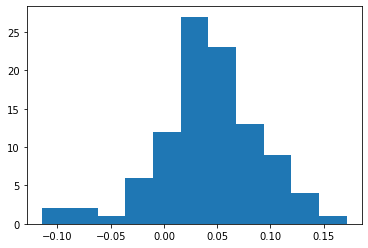

In [473]:
_=plt.hist(results_single[:,1], bins=11)

In [474]:
(results_single[:,1]>0).mean() * 100

77.0

In [475]:
(results_single[:,1]==0).mean() * 100

12.0

In [476]:
(results_single[:,1]<0).mean() * 100

11.0

# build final classifiers

In [477]:
dataset = data_split(feature_1st_stage, labels)

In [478]:
train_dataset, valid_dataset = dataset
train_features, train_labels = train_dataset
valid_features, valid_labels = valid_dataset

clf = XGBClassifier(**params)
clf.fit(train_features, train_labels)

predicted_train = clf.predict(train_features)
train_acc = (predicted_train == train_labels).mean()

predicted_valid = clf.predict(valid_features)
valid_acc = (predicted_valid == valid_labels).mean()

print (train_labels.mean(), valid_labels.mean())
print (train_acc, valid_acc)

0.7697841726618705 0.6857142857142857
0.935251798561151 0.8285714285714286


In [481]:
clf = XGBClassifier(**params)
clf.fit(features_8[:,np.argsort(rank_summary)[:175]][:,feature_importance > 0.015], labels_8)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.2,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=2, missing=None, n_estimators=100, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [486]:
test_feature = features_2[:,np.argsort(rank_summary)[:175]][:,feature_importance > 0.015]

In [487]:
predicted_test = clf.predict(test_feature)
test_acc = (predicted_test == labels_2).mean()

In [488]:
test_acc

0.8571428571428571

In [489]:
labels_2.mean()

0.7714285714285715

In [490]:
import pickle

In [491]:
with open('final_classifier_CN.pkl', 'wb') as f:
    pickle.dump([clf, selected_feature_names[feature_importance > 0.01], feature_map_tables], f)

# model usage:
    load the model file with pickle, get a tuple of (classifier, feature_names, feature_map_table)
    find feature mentioned in feature_names, if it is in the feature_map_tables, map it with its index, use classifier to get the result.

In [532]:
with open('final_classifier_CN.pkl', 'rb') as f:
    classifier, feature_names, map_table = pickle.load(f)

In [493]:
from sklearn.metrics import confusion_matrix, roc_auc_score

confusion_matrixs = []
roc_aucs = []

In [494]:
for i in range(100):
    print('\r%2d/%2d  ' % (i+1,100), end='')
    train_dataset, valid_dataset = data_split(feature_1st_stage, labels)
    train_features, train_labels = train_dataset
    valid_features, valid_labels = valid_dataset
    
    clf = XGBClassifier(**params)
    clf.fit(train_features, train_labels)
    
    predicted_proba_valid = clf.predict_proba(valid_features)
    predicted_valid = clf.predict(valid_features)
    
    confusion_matrixs.append(confusion_matrix(y_true=valid_labels, y_pred=predicted_valid))
    roc_aucs.append(roc_auc_score(y_true=valid_labels, y_score=predicted_proba_valid[:,1]))

100/100  

In [499]:
averaged_confusion_matrix = np.array(confusion_matrixs).mean(axis=0)

tn, fp, fn, tp = averaged_confusion_matrix.ravel()

# specificity
print ('specificity: %.4f' % (tn/(tn+fp)))

# sensitivity
print ('sensitivity: %.4f' % (tp/(tp+fn)))

specificity: 0.3040
sensitivity: 0.9398


In [500]:
np.array(roc_aucs).mean()

0.7496540924324822

0.7496540924324822